In [1]:
import zipfile

In [2]:
import os
print(os.listdir('/content/'))

['.config', 'archive (2).zip', 'Vegetable Images', 'sample_data']


In [3]:
import os

file_path = '/content/archive (2).zip'

if os.path.exists(file_path):
  print(f"File '{file_path}' exists.")
  with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()
else:
  print(f"File '{file_path}' does not exist. Please check the path and ensure the file is uploaded correctly.")

File '/content/archive (2).zip' exists.


In [4]:
with zipfile.ZipFile('/content/archive (2).zip','r') as zip_ref:
  zip_ref.extractall()

In [5]:
import os
for dirpath,dirnames,filenames in os.walk('/content/Vegetable Images'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}.")

There are 3 directories and 0 images in '/content/Vegetable Images.
There are 15 directories and 0 images in '/content/Vegetable Images/validation.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Carrot.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Bottle_Gourd.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Pumpkin.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Brinjal.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Tomato.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Papaya.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Bean.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Potato.
There are 0 directories and 200 images in '/content/Vegetable Images/validation/Bitter_Gourd.
There are 0 directories and 200 images in '/cont

In [6]:
num_vegetableimg_train=len(os.listdir('/content/Vegetable Images/train/Cabbage'))
num_vegetableimg_train

1000

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pathlib

def view_random_image(target_dir,target_class,num_images=9):
  path=target_dir +target_class
  img_paths = os.listdir(path)
  num_images = min(num_images, len(img_paths))
  selected_paths = random.sample(img_paths, num_images)
  plt.figure(figsize=(12, 12))
  for i in range(num_images):
        plt.subplot(3, 3, i+1)
        img_path=path +'/'+selected_paths[i]
        img=mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(target_class)
        plt.axis('off')
  print(f"image shape: {img.shape}")

image shape: (224, 224, 3)


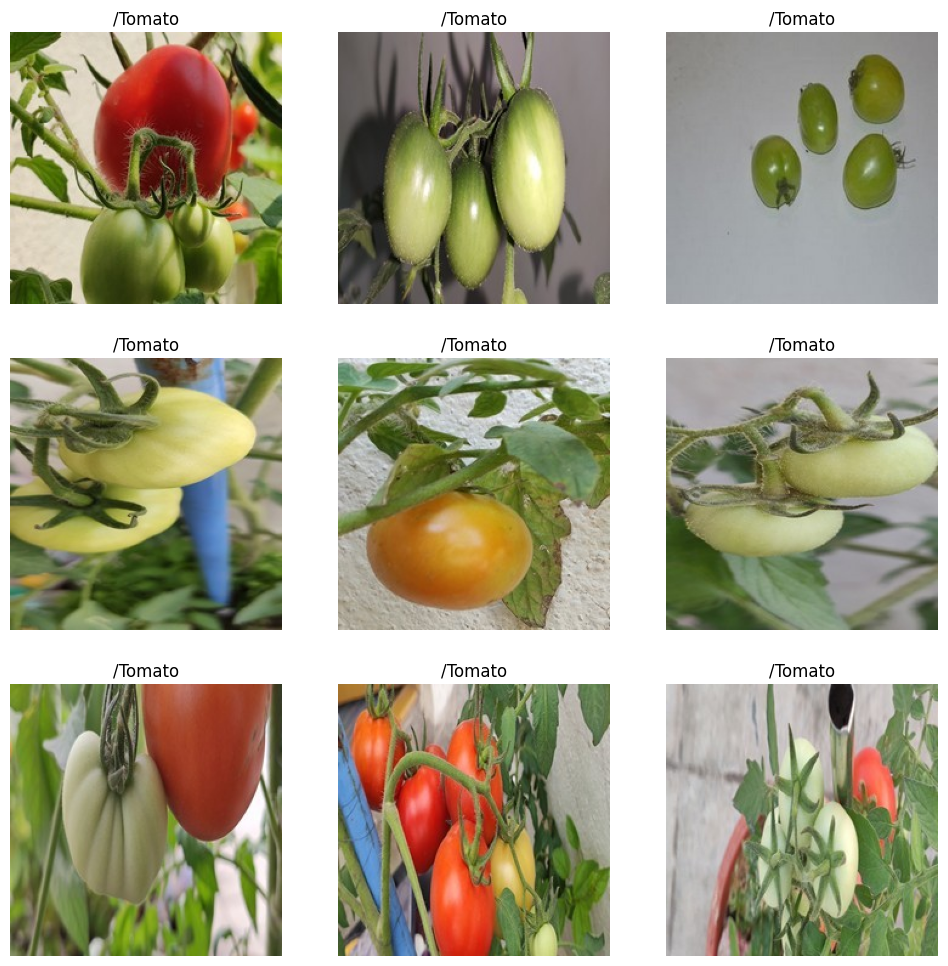

In [8]:
view_random_image(target_dir='/content/Vegetable Images/train',target_class='/Tomato')

In [9]:
import tensorflow as tf
IMG_SIZE=(224,224)

train_dir='/content/Vegetable Images/train'
test_dir='/content/Vegetable Images/test'
valid_dir='/content/Vegetable Images/validation'

train_data_raw=tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode='categorical',
                                                               image_size=IMG_SIZE,shuffle=True,crop_to_aspect_ratio=True)

test_data_raw=tf.keras.preprocessing.image_dataset_from_directory(test_dir,image_size=IMG_SIZE,label_mode='categorical',crop_to_aspect_ratio=True)

valid_data_raw=tf.keras.preprocessing.image_dataset_from_directory(valid_dir,image_size=IMG_SIZE,label_mode='categorical',crop_to_aspect_ratio=True)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [10]:
tf.keras.backend.clear_session()
batch_size=32

preprocess=tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_data=train_data_raw.map(lambda X,y: (preprocess(X),y))
train_data=train_data.shuffle(1000,seed=42).prefetch(1)
valid_data=valid_data_raw.map(lambda X,y: (preprocess(X),y))
test_data=test_data_raw.map(lambda X,y: (preprocess(X),y))

In [11]:
for image_batch, label_batch in valid_data.take(1):
    print("Batch shape:", image_batch.shape)
    print("Single image shape:", image_batch[0].shape)


Batch shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)


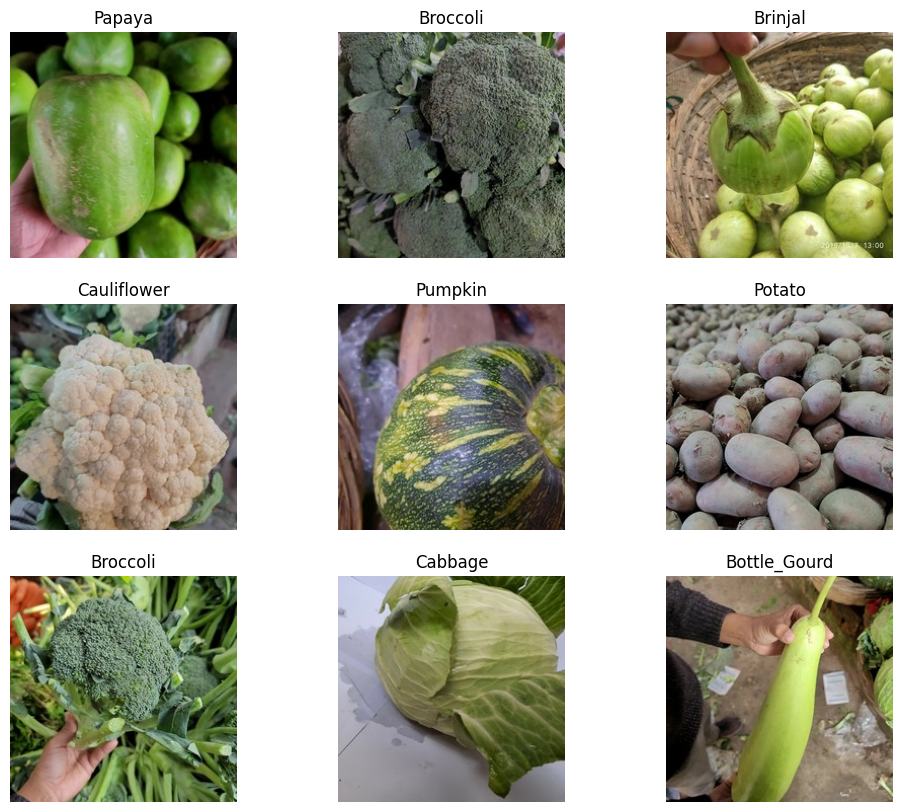

In [12]:
import matplotlib.pyplot as plt
import numpy as np
class_names = train_data_raw.class_names


plt.figure(figsize=(12,10))
for image_batch,label_batch in valid_data.take(1):
  for index in range(9):
    plt.subplot(3,3,index+1)
    plt.imshow(((image_batch[index].numpy()) + 1) / 2)

    plt.title(class_names[np.argmax(label_batch[index])])
    plt.axis('off');

In [13]:
n_classes=len(class_names)

In [14]:
n_classes

15

In [15]:
data_augementation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal',seed=42),
    tf.keras.layers.RandomRotation(factor=0.4,seed=42)
])

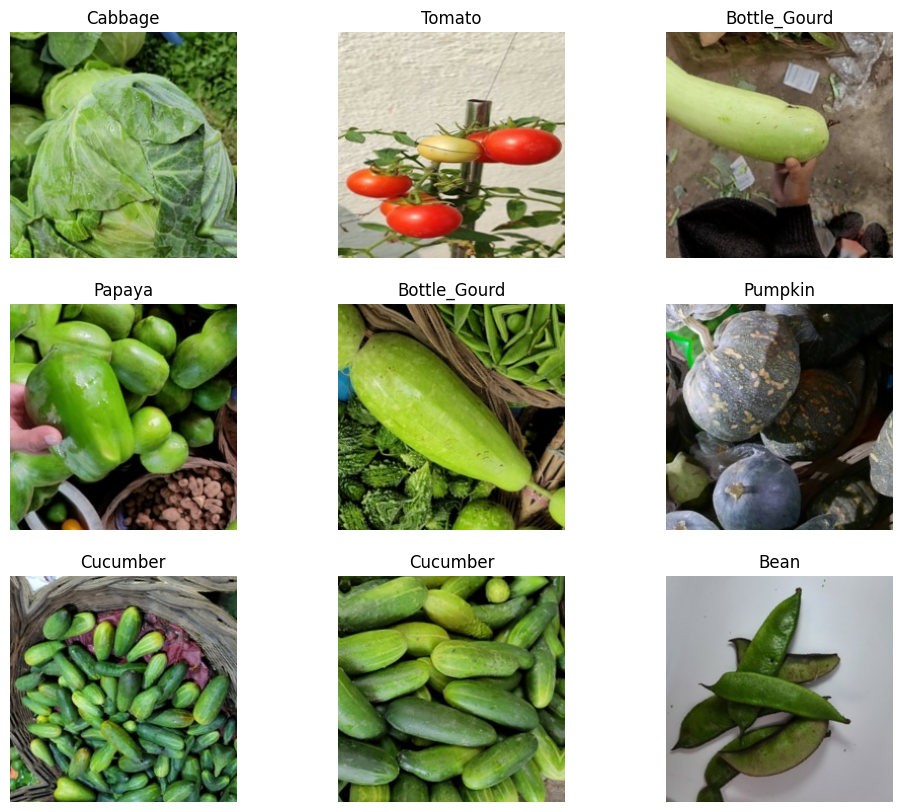

In [16]:
plt.figure(figsize=(12,10))
for X_batch,y_batch in train_data.take(1):
  X_batch_augemented=data_augementation(X_batch)
  for index in range(9):
    plt.subplot(3,3,index+1)
    plt.imshow(((X_batch_augemented[index].numpy())/2)+0.5)
    plt.axis('off')
    plt.title(class_names[np.argmax(y_batch[index])])

In [17]:
tf.random.set_seed(42)

base_model=tf.keras.applications.xception.Xception(weights='imagenet',include_top=False)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(n_classes,activation='softmax')(avg)
model=tf.keras.Model(inputs=base_model.input,outputs=output)

In [18]:
for layer in base_model.layers:
  layer.trainable=False

In [19]:
optimizer=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history=model.fit(train_data,validation_data=valid_data,epochs=5)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 165ms/step - accuracy: 0.9197 - loss: 0.2584 - val_accuracy: 0.9940 - val_loss: 0.0188
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 123s 145ms/step - accuracy: 0.9949 - loss: 0.0144 - val_accuracy: 0.9957 - val_loss: 0.0136
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 169ms/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9960 - val_loss: 0.0109
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.9973 - val_loss: 0.0101
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 92s 171ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9973 - val_loss: 0.0110


In [23]:
for layer in base_model.layers[100:]:
  layer.trainable=True
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history=model.fit(train_data,validation_data=valid_data,epochs=5)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 227ms/step - accuracy: 0.9801 - loss: 0.1247 - val_accuracy: 0.9973 - val_loss: 0.0127
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 128s 214ms/step - accuracy: 0.9976 - loss: 0.0164 - val_accuracy: 0.9980 - val_loss: 0.0101
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 121s 220ms/step - accuracy: 0.9989 - loss: 0.0102 - val_accuracy: 0.9980 - val_loss: 0.0086
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 222ms/step - accuracy: 0.9988 - loss: 0.0090 - val_accuracy: 0.9980 - val_loss: 0.0072
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 127s 241ms/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9980 - val_loss: 0.0065


In [24]:
test_loss, test_acc = model.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9967 - loss: 0.0129
